# 5. Dataset & Dataloader

## Reference

- [Pytorch Dataset, Dataloader 튜토리얼](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

<br>

## 5.1 모델에 데이터를 먹이는 방법

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://drive.google.com/uc?id=1ImmcHNDcJ7PtcEFJO0bN4o4NX5pXv5-8' width=800/>

<br>

## 5.2 `Dataset` 클래스

> 하나의 데이터를 어떻게 가져올 것인가?

- 데이터 입력 형태를 정의하는 클래스
- 데이터를 입력하는 방식의 표준화
- Image, Text, Audio 등에 따른 다른 입력정의

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # 초기 데이터 생성 방법을 지정
    def __init__(self, text, labels):
        self.labels = labels
        self.data = text

    # 데이터의 전체 길이
    def __len__(self):
        return len(self.labels)

    # index 값을 주었을 때 반환되는 데이터의 형태 (X, y)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.data[idx]
        sample = {"Text": text, "Class": label} # 일반적으로 classification 문제에서는 dict type 으로 반환
        return sample

In [8]:
# Dataset 생성
text = ['Happy', 'Amazing', 'Sad', 'Unhapy', 'Glum']
labels = ['Positive', 'Positive', 'Negative', 'Negative', 'Negative']
MyDataset = CustomDataset(text, labels)

<br>

### 5.2.1 `Dataset` 클래스 생성 시 유의점

- 데이터 형태에 따라 각 함수를 다르게 정의함
- 모든 것을 데이터 생성 시점에 처리할 필요는 없음
  - image의 Tensor 변화는 학습에 필요한 시점에 변환
- 데이터 셋에 대한 표준화된 처리방법 제공 필요
  - 후속 연구자 또는 동료에게는 빛과 같은 존재
- 최근에는 HuggingFace등 표준화된 라이브러리 사용

<br>

## 5.3 `DataLoader` 클래스

> 인덱스를 가지고 여러 개의 데이터를 묶어서 모델에 던져주는 역할

- Data의 Batch를 생성해주는 클래스
- 학습직전(GPU feed전) 데이터의 변환을 책임
- Tensor로 변환 + Batch 처리가 메인 업무
- 병렬적인 데이터 전처리 코드의 고민 필요

In [5]:
# DataLoader Generator
MyDataLoader = DataLoader(MyDataset, batch_size=2, shuffle=True)
next(iter(MyDataLoader))

{'Class': ['Negative', 'Negative'], 'Text': ['Glum', 'Sad']}

In [6]:
MyDataLoader = DataLoader(MyDataset, batch_size=2, shuffle=True)
for dataset in MyDataLoader:
    print(dataset)

{'Text': ['Happy', 'Amazing'], 'Class': ['Positive', 'Positive']}
{'Text': ['Unhapy', 'Glum'], 'Class': ['Negative', 'Negative']}
{'Text': ['Sad'], 'Class': ['Negative']}


In [9]:
MyDataLoader = DataLoader(MyDataset, batch_size=3, shuffle=True)
for dataset in MyDataLoader:
    print(dataset)

{'Text': ['Sad', 'Unhapy', 'Happy'], 'Class': ['Negative', 'Negative', 'Positive']}
{'Text': ['Amazing', 'Glum'], 'Class': ['Positive', 'Negative']}


<br>

### 5.3.1 `DataLoader` 클래스의 파라미터

```python
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,pin_memory=False,
           drop_last=False, timeout=0,worker_init_fn=None,*, prefetch_factor=2,
           persistent_workers=False
)
```

- 출처: https://subinium.github.io/pytorch-dataloader/

<br>

- `sampler`
  - sampler는 index를 컨트롤하는 방법
  - 데이터의 index를 원하는 방식대로 조정
  - index를 컨트롤하기 때문에 설정하고 싶다면 `shuffle` 파라미터는 `False`(기본값)여야 한다.
- `batch_sampler`
  - `sampler` 와 거의 동일
- `collate_fn`
  - map-style 데이터셋에서 sample list를 batch 단위로 바꾸기 위해 필요한 기능
  - zero-padding이나 Variable Size 데이터 등 데이터 사이즈를 맞추기 위해 많이 사용
    - 왜 쓰는 지를 알면 좋다.

<br>

## 5.4 Dataset Sources

- [torchvision documentation](https://pytorch.org/vision/stable/datasets.html) 에서 다양한 종류의 데이터셋의 구조를 확인할 수 있다.
  - clone coding 권장

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://drive.google.com/uc?id=1Mrfk_DFzhoGg9D3MR1HYSf3P9yfXb-7F' width=600/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://drive.google.com/uc?id=1nyUftCQNKXJEJqS5l0aS_FGQ-bncF0Fx' width=500/>

<br>

## 5.5 Casestudy

- 데이터 다운로드 부터 loader까지 직접 구현해보기
- NotMNIST 데이터의 다운로드 자동화 도전

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://drive.google.com/uc?id=1b7zVNt74rPgJ3Y8tc0o2zvMfT7mlr2_w' width=500/>

- 출처: http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html

<br>

### 5.5.1 실습: Custom Dataset

In [10]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple
import os

from tqdm import tqdm
import os
import sys
from pathlib import Path
import requests

from skimage import io, transform
import matplotlib.pyplot as plt

In [11]:
import tarfile

class NotMNIST(VisionDataset):
    resource_url = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz'

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False
    ) -> None:
        super(NotMNIST, self).__init__(root, transform=transform, target_transform=target_transform)

        if not self._check_exists() or download: # 존재하는 지 확인
            self.download()

        if download: # download=True 이면 download
            self.download()

        self.data, self.targets = self._load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = self.data[index]
        image = io.imread(image_name)
        label = self.targets[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def _load_data(self):
        filepath = self.image_folder
        data = []
        targets = []

        # filename 을 리스트로 만들어서 data 로 반환
        # 디렉토리의 이름(A, B, C, ...)을 target 으로 반환
        for target in os.listdir(filepath):
            filenames = [os.path.abspath(
                os.path.join(filepath, target, x)) for x in os.listdir(
                os.path.join(filepath, target))]
            
            targets.extend([target] * len(filenames))
            data.extend(filenames)
        return data, targets

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def image_folder(self) -> str:
        return os.path.join(self.root, 'notMNIST_large')


    def download(self) -> None:
        os.makedirs(self.raw_folder, exist_ok=True) # 디렉토리를 raw_folder 로 만든다.
        fname = self.resource_url.split("/")[-1] # 파일명을 가져온다.
        chunk_size = 1024
        
        filesize = int(requests.head(self.resource_url).headers["Content-Length"])
        
        # 파일 다운로드
        with requests.get(self.resource_url, stream=True) as r, open(
            os.path.join(self.raw_folder, fname), "wb") as f, tqdm(
            unit="B",  # unit string to be displayed.
            unit_scale=True,  # let tqdm to determine the scale in kilo, mega..etc.
            unit_divisor=1024,  # is used when unit_scale is true
            total=filesize,  # the total iteration.
            file=sys.stdout,  # default goes to stderr, this is the display on console.
            desc=fname  # prefix to be displayed on progress bar.
        ) as progress:
            for chunk in r.iter_content(chunk_size=chunk_size):
                # download the file chunk by chunk
                datasize = f.write(chunk)
                # on each chunk update the progress bar.
                progress.update(datasize)
        
        # 압축 해제
        self._extract_file(os.path.join(self.raw_folder, fname), target_path=self.root)
        
    def _extract_file(self, fname, target_path) -> None:
        if fname.endswith("tar.gz"):
            tag = "r:gz"
        elif fname.endswith("tar"):
            tag = "r:"
        tar = tarfile.open(fname, tag)
        tar.extractall(path=target_path)
        tar.close()
    
    def _check_exists(self) -> bool:
        return os.path.exists(self.raw_folder)                        

In [12]:
dataset = NotMNIST('data', download=True)

notMNIST_large.tar.gz: 100%|██████████| 236M/236M [00:05<00:00, 43.5MB/s]


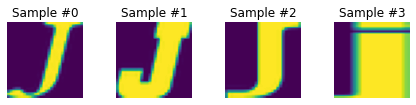

In [15]:
fig = plt.figure()

for i in range(8):
    sample = dataset[i]

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0])

    if i == 3:
        plt.show()
        break

In [16]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # PyTorch 에서 처리할 수 있는 형태인 텐서로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

dataset = NotMNIST('data', download=False)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:917: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [17]:
dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=128,
                                             shuffle=True)

In [18]:
train_features, train_labels = next(iter(dataset_loader))

In [19]:
train_features.shape

torch.Size([128, 28, 28])

In [20]:
train_features[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   4,   0, 107, 255, 251, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 253, 255, 208],
        [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0, 159, 255, 253, 255,
         255, 255, 255, 255, 255, 254, 255, 255, 255, 255, 255, 253, 255, 158],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  29,  37,  37,  38,
          40,  41,  43,  40,  77, 252, 255, 124,  39,  43,  40,  37,  37,  17],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,  78, 253, 254,  57,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   4,   0,   3,
          52, 115, 158, 187, 243, 255, 236,   6,  39, 174, 125,   0,   3,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,  64, 201,
         255, 255, 255, 213, 177, 214, 228,  64, 246, 255, 255, 119,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   

In [25]:
print(train_labels)

('G', 'E', 'E', 'C', 'G', 'G', 'J', 'I', 'C', 'F', 'I', 'C', 'B', 'C', 'D', 'E', 'E', 'D', 'J', 'G', 'H', 'B', 'B', 'C', 'D', 'A', 'B', 'J', 'I', 'C', 'E', 'I', 'E', 'E', 'C', 'J', 'G', 'D', 'E', 'G', 'F', 'I', 'C', 'J', 'D', 'E', 'D', 'G', 'C', 'E', 'G', 'I', 'H', 'J', 'J', 'E', 'F', 'D', 'C', 'J', 'D', 'G', 'D', 'A', 'C', 'B', 'I', 'C', 'J', 'F', 'F', 'B', 'J', 'J', 'F', 'E', 'H', 'A', 'F', 'B', 'I', 'C', 'H', 'D', 'G', 'I', 'D', 'G', 'I', 'D', 'E', 'F', 'C', 'D', 'C', 'H', 'E', 'H', 'C', 'G', 'I', 'D', 'J', 'A', 'F', 'H', 'A', 'A', 'I', 'B', 'A', 'E', 'H', 'F', 'A', 'E', 'G', 'H', 'C', 'C', 'J', 'D', 'D', 'E', 'G', 'C', 'E', 'G')
